In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, make_scorer, f1_score, accuracy_score

In [2]:
kappa_scorer = make_scorer(cohen_kappa_score)

def fit_model(myclf, traindata, testdata, trainoutcome, testoutcome):
    myclf.fit(traindata, trainoutcome)
    print("Best Model:")
    print(myclf.best_estimator_)
    
    y_pred_train = myclf.best_estimator_.predict(traindata)
    y_pred_test = myclf.best_estimator_.predict(testdata)
    
    y_predprob_train = myclf.best_estimator_.predict_proba(traindata)[:, 1]
    y_predprob_test = myclf.best_estimator_.predict_proba(testdata)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(trainoutcome, y_predprob_train)
    fpr_test, tpr_test, _ = roc_curve(testoutcome, y_predprob_test)
    
    acc_train = accuracy_score(trainoutcome, y_pred_train)
    acc_test = accuracy_score(testoutcome, y_pred_test)
    kap_train = cohen_kappa_score(trainoutcome, y_pred_train)
    kap_test = cohen_kappa_score(testoutcome, y_pred_test)
    
    cm_train = confusion_matrix(trainoutcome, y_pred_train)
    cm_test = confusion_matrix(testoutcome, y_pred_test)
    print("Training set confusion matrix:")
    print(cm_train)
    print("Test set confusion matrix:")
    print(cm_test)
    
    x = pd.DataFrame({'Train_Accuracy': [acc_train],
        'Test_Accuracy': [acc_test],
        'Train_Kappa': [kap_train],
        'Test_Kappa': [kap_test]})
    print(x)
    train_outcome_df = pd.DataFrame({'Outcome': trainoutcome,
                                    'Predicted': y_pred_train})
    test_outcome_df = pd.DataFrame({'Outcome': testoutcome,
                                   'Predicted': y_pred_test})
    
    
    # plot ROC
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    
    return(myclf, x, train_outcome_df, test_outcome_df)

In [20]:
CFCdata = pd.read_csv('NewDataDec19_code/CFC_features_clean.csv')

X = CFCdata.iloc[:, 3:8]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train = X[CFCdata.Group=="Train",:]
X_test = X[CFCdata.Group=="Test",:]

y_train = CFCdata.Survive[CFCdata.Group=="Train"]
y_test = CFCdata.Survive[CFCdata.Group=="Test"]

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Model:
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Training set confusion matrix:
[[ 61  19]
 [ 21 130]]
Test set confusion matrix:
[[10  6]
 [ 0  8]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0         0.82684           0.75     0.619784    0.526316


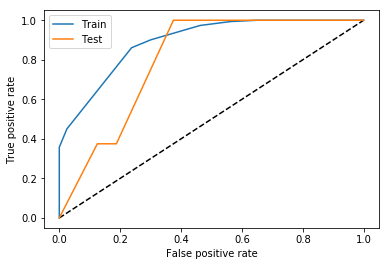

In [22]:
min_samples_split_DT = [3,4,5,6,7,8,9]
min_samples_leaf_DT = [3,4,5,6,7,8,9]
max_depth_DT = [3,4,5,6,7,8,9,10]
max_features_DT = ['sqrt', 'log2', None, 1, 2, 3, 4, 5]

parameters_DT = {'max_features':max_features_DT,
                'min_samples_split': min_samples_split_DT,
                 'max_depth': max_depth_DT,
                'min_samples_leaf': min_samples_leaf_DT
                }

DT_model = DecisionTreeClassifier(random_state=0, splitter='best', criterion='gini', class_weight='balanced')
DT_clf = GridSearchCV(DT_model, parameters_DT, cv=5, scoring=kappa_scorer)
DT_clf, DT_performance, DT_train, DT_test = fit_model(DT_clf, X_train, X_test, y_train, y_test)


Best Model:
LogisticRegression(C=1.9306977288832496, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Training set confusion matrix:
[[ 47  33]
 [  8 143]]
Test set confusion matrix:
[[16  0]
 [ 6  2]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.822511           0.75     0.576904    0.307692


D:\defne\Apps\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


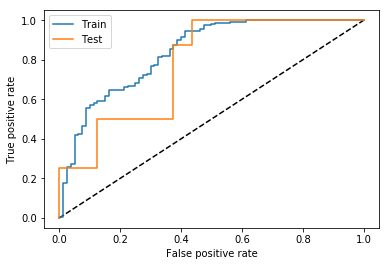

In [32]:
penalty_list_LR = ['l1','l2']
regularization_list_LR = [i for i in np.logspace(-4,2,15)]
parameters_LR = {'penalty':penalty_list_LR,
                'C': regularization_list_LR
                }

LR_model = LogisticRegression(class_weight = 'balanced', solver="liblinear")
LR_clf = GridSearchCV(LR_model, parameters_LR, cv=5, scoring=kappa_scorer)

LR_clf, LR_performance, LR_train, LR_test = fit_model(LR_clf, X_train, X_test, y_train, y_test)


Best Model:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')
Training set confusion matrix:
[[ 37  43]
 [  5 146]]
Test set confusion matrix:
[[ 6 10]
 [ 0  8]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.792208       0.583333     0.483366    0.285714


D:\defne\Apps\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


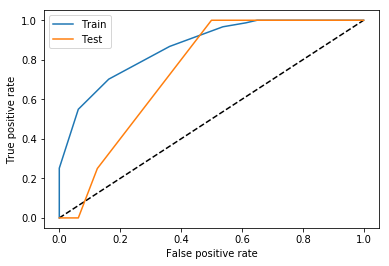

In [24]:
nneighbors_KNN = [i+2 for i in range(10)]
weights_list_KNN = ['uniform', 'distance']
parameters_KNN = {'n_neighbors':nneighbors_KNN,
                'weights': weights_list_KNN}
KNN_model = KNeighborsClassifier()
KNN_clf = GridSearchCV(KNN_model, parameters_KNN, cv=5, scoring=kappa_scorer)
KNN_clf, KNN_performance, KNN_train, KNN_test = fit_model(KNN_clf, X_train, X_test, y_train, y_test)

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Model:
SVC(C=0.03727593720314938, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Training set confusion matrix:
[[ 38  42]
 [  7 144]]
Test set confusion matrix:
[[7 9]
 [0 8]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.787879          0.625     0.477785    0.341463


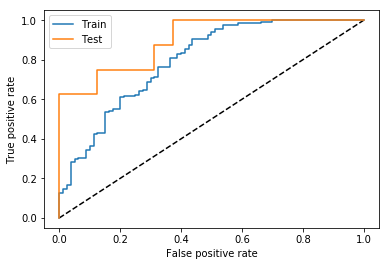

In [39]:
shrinking_list_SVM = [True, False]
regularization_list_SVM = [i for i in np.logspace(-4,-1,15)]
kernel_list_SVM = ['linear', 'poly', 'rbf', 'sigmoid']
parameters_SVM = {'shrinking':shrinking_list_SVM,
                  'kernel': kernel_list_SVM,
                'C': regularization_list_SVM}

SVM_model = svm.SVC(class_weight='balanced', probability=True, gamma="scale")
SVM_clf = GridSearchCV(SVM_model, parameters_SVM, cv=5, scoring=kappa_scorer)
SVM_clf, SVM_performance, SVM_train, SVM_test = fit_model(SVM_clf, X_train, X_test, y_train, y_test)

Best Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Training set confusion matrix:
[[ 80   0]
 [  0 151]]
Test set confusion matrix:
[[9 7]
 [0 8]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0       0.708333          1.0    0.461538


D:\defne\Apps\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


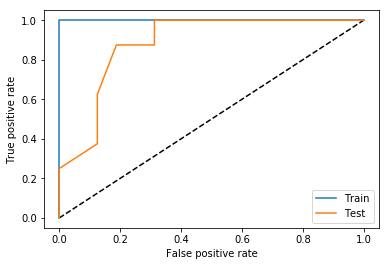

In [29]:
n_estimators_RF = [50, 100, 250, 500, 1000]
max_features_RF = [ None, 'sqrt', 'log2', 'auto']
parameters_RF = {'n_estimators': n_estimators_RF,
                'max_features': max_features_RF}

RF_model = RandomForestClassifier(max_depth=None,
                                  min_samples_split=2, random_state=0)
RF_clf = GridSearchCV(RF_model, parameters_RF, cv=5, scoring=kappa_scorer)
RF_clf, RF_performance, RF_train, RF_test = fit_model(RF_clf, X_train, X_test, y_train, y_test)

In [36]:
CFC_predictions = CFCdata.copy(deep=True)
CFC_predictions['DT'] = DT_clf.best_estimator_.predict_proba(X)[:,1]
CFC_predictions['LR'] = LR_clf.best_estimator_.predict_proba(X)[:,1]
CFC_predictions['KNN'] = KNN_clf.best_estimator_.predict_proba(X)[:,1]
CFC_predictions['SVM'] = SVM_clf.best_estimator_.predict_proba(X)[:,1]
CFC_predictions['RF'] = RF_clf.best_estimator_.predict_proba(X)[:,1]

In [37]:
CFC_predictions.to_csv('NewDataDec19_code/CFC_predictions.csv')